In [3]:
run __init__.py

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
init_notebook_mode(connected=True)
from joblib import load, dump
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from langdetect import detect
from finnhub_api import Finnhub
from project import Project
from nlp import NLP_stat
from datetime_util import timestamp2datetime, str2date, str2datetime

[nltk_data] Downloading package stopwords to /Users/boula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/boula/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/boula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Collecting

In [3]:
# loading news data scrapted by SNA api
df_news = pd.read_csv('./data/apple_news_raw.csv.gz')

In [4]:
# loading articles list previously scraped by scrapy.py we include in ./lib
articles = load('./data/articles.pkl')

In [5]:
df_news['articles'] = articles

In [6]:
df_news.head(3)

,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers,articles
0,https://www.cnbc.com/2021/05/25/home-prices-in...,https://cdn.snapi.dev/images/v1/b/m/104669168-...,Home prices in March saw highest growth in ove...,"Home prices in March were up 13%, one of the l...",CNBC,"Tue, 25 May 2021 09:01:19 -0400",[],Neutral,Article,NaN,Home prices in March were 13.2% higher in Mar...
1,https://www.reuters.com/article/us-usa-economy...,https://cdn.snapi.dev/images/v1/a/s/m02d202105...,U.S. home prices rose more than expected in Ma...,U.S. single-family home prices in 20 key urban...,Reuters,"Tue, 25 May 2021 09:09:00 -0400",[],Neutral,Article,NaN,U.S. single-family home prices in 20 key urban...
2,https://www.reuters.com/article/us-usa-economy...,https://cdn.snapi.dev/images/v1/8/c/m02d202105...,U.S. new home sales drop in April; March sales...,Sales of new U.S. single-family homes dropped ...,Reuters,"Tue, 25 May 2021 10:33:00 -0400",[],Negative,Article,NaN,A carpenter works on building new townhomes th...


## Data Scrubbing

In [7]:
# drop unnecessary columns
cols_to_drop = ['news_url', 'image_url', 'title', 'text', 'topics', 'type', 'tickers']
df_news.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
df_news

,source_name,date,sentiment,articles
0,CNBC,"Tue, 25 May 2021 09:01:19 -0400",Neutral,Home prices in March were 13.2% higher in Mar...
1,Reuters,"Tue, 25 May 2021 09:09:00 -0400",Neutral,U.S. single-family home prices in 20 key urban...
2,Reuters,"Tue, 25 May 2021 10:33:00 -0400",Negative,A carpenter works on building new townhomes th...
3,Reuters,"Tue, 25 May 2021 07:10:00 -0400",Positive,Wall Street bank chiefs will tout the role the...
4,CNN Business,"Tue, 25 May 2021 12:30:41 -0400",Negative,"By Paul R. La Monica, CNN Business Updated 12..."
...,...,...,...,...
10445,CNET,"Mon, 26 Apr 2021 15:14:00 -0400",Negative,Tim Cook and Mark Zuckerberg's relationship st...
10446,Proactive Investors,"Mon, 26 Apr 2021 04:54:18 -0400",Neutral,Pharma & Biotech Coronavirus Cannabis Battery ...
10447,Zacks Investment Research,"Mon, 26 Apr 2021 17:31:17 -0400",Positive,We use cookies to understand how you use our s...
10448,The Motley Fool,"Sun, 25 Apr 2021 12:35:00 -0400",Positive,Returns as of 5/27/2021 Returns as of 5/27/202...


In [9]:
miss_articles = df_news['articles'].isna()
print(f"Total Missing Articles: {miss_articles.sum()}")

Total Missing Articles: 923


As result of scraping 10,450 websites we got 91.13% of successful scraped articles, but we also end up missing  926 websites. this probably due to websites restriction like cookies and CAPTCHA Blocking,  IP Blocking & Proxy Servers, etc..

those 926 row are going to be droped from our dataframe

In [10]:
df_news.drop(df_news.loc[miss_articles].index, inplace=True)

In [11]:
df_news.reset_index(drop=True, inplace=True)

#### DateTime

In [12]:
df_news.loc[:5,'date']

0    Tue, 25 May 2021 09:01:19 -0400
1    Tue, 25 May 2021 09:09:00 -0400
2    Tue, 25 May 2021 10:33:00 -0400
3    Tue, 25 May 2021 07:10:00 -0400
4    Tue, 25 May 2021 12:30:41 -0400
5    Tue, 25 May 2021 02:07:04 -0400
Name: date, dtype: object

In [13]:
df_news['date'].str.findall("\s-[0-9]{4}$").apply(lambda x: ''.join(x)).unique()

array([' -0400', ' -0500'], dtype=object)

In [14]:
# we found dates end with noise strings like '-0400' and '-0500', those are going to be removed using
# builin pandas RegEx.
df_news['date'] = df_news['date'].str.replace("\s-[0-9]{4}$", '', regex=True)

In [15]:
# convert date from string date format to DateTime object using standard ISO-8601 formated YYYY-MM-DDTHH:MM:SS.
df_news['date'] = pd.to_datetime(df_news['date'], format="%a, %d %b %Y %H:%M:%S")

In [16]:
df_news.loc[:5,'date']

0   2021-05-25 09:01:19
1   2021-05-25 09:09:00
2   2021-05-25 10:33:00
3   2021-05-25 07:10:00
4   2021-05-25 12:30:41
5   2021-05-25 02:07:04
Name: date, dtype: datetime64[ns]

In [17]:
df_news['date'] = pd.to_datetime(df_news['date']).dt.normalize()

In [18]:
df_news.rename(columns={'source_name':'source'}, inplace=True)

Using langdetect in order to indentify articles language, ensure articles are only english

In [19]:
df_news.reset_index(drop=True, inplace=True)

In [20]:
df_news.head()

,source,date,sentiment,articles
0,CNBC,2021-05-25,Neutral,Home prices in March were 13.2% higher in Mar...
1,Reuters,2021-05-25,Neutral,U.S. single-family home prices in 20 key urban...
2,Reuters,2021-05-25,Negative,A carpenter works on building new townhomes th...
3,Reuters,2021-05-25,Positive,Wall Street bank chiefs will tout the role the...
4,CNN Business,2021-05-25,Negative,"By Paul R. La Monica, CNN Business Updated 12..."


## PREPROCESSING

In this section we start by preparing our data for modeling, first by cleaning and tokenizing the articles text applying the function 'text_tokenize' and lastely evaluate the sentiment analysis applying 'polarity_score function.

Text Tonkenization

Remove punctuation, special characters, numbers

In [21]:
prep = NLP_stat()

In [22]:
df_news['articles'] = df_news['articles'].apply(lambda txt: txt.lower())

In [23]:
stop_words=stopwords.words('english')
df_news['articles'] = df_news['articles']\
                            .apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))

In [24]:
df_news['articles'] = df_news['articles'].apply(lambda txt: sent_tokenize(txt))
df_news['articles'] = df_news['articles'].apply(lambda x: ' '.join(x))

In [25]:
word_tokenizer = RegexpTokenizer('[a-zA-Z]+')
df_news['articles'] = df_news['articles'].apply(lambda txt: word_tokenizer.tokenize(txt))
df_news['articles'] = df_news['articles'].apply(lambda txt: ' '.join(txt))

In [26]:
single_chars = re.compile(r"(^\w{1})(?=\s)|(?<=\s)[\w]{1}(?=\s)")
df_news['articles'] = df_news['articles'].apply(lambda txt: single_chars.sub('', txt))

In [27]:
articles_to_drop = df_news[(df_news['articles'].apply(lambda x: len(x.split()) <= 10))].index
df_news.drop(articles_to_drop, inplace=True)

In [28]:
df_news.reset_index(drop=True, inplace=True)

In [30]:
df_news.to_csv('./data/apple_news_cleaned.csv.gz', compression="gzip")

## Features Engineering

In [5]:
df_news = pd.read_csv('./data/apple_news_cleaned.csv.gz', index_col=0)

In [7]:
prep = NLP_stat()

In [8]:
df_score = prep.polarity_score(df_news['articles'])

In [9]:
df_news = pd.concat([df_news.drop('articles', axis=1), df_score], axis=1, ignore_index=False, sort=False)

In [10]:
df_news.rename(columns={"text":"articles"}, inplace=True)

In [11]:
# create a Frequency Distribution of postive words
positive_fdist_df = prep.get_freq_dist(
    prep.get_word_list( df_news[(df_news['sentiment'] == 'Positive')].loc[:,'articles'] )
) 

In [12]:
# create a Frequency Distribution of negative words
negative_fdist_df = prep.get_freq_dist(
    prep.get_word_list( df_news[(df_news['sentiment'] == 'Negative')].loc[:,'articles'] )
) 

In [13]:
# create a Frequency Distribution of neutral words
neutral_fdist_df = prep.get_freq_dist(
    prep.get_word_list( df_news[(df_news['sentiment'] == 'Neutral')].loc[:,'articles'] )
) 

In [14]:
# create a Frequency Distribution of all words
fdist_df = prep.get_freq_dist(prep.get_word_list(df_news['articles']))

In [15]:
df_news['sentiment'].value_counts()

Positive    4356
Neutral     3024
Negative    2140
Name: sentiment, dtype: int64

In [16]:
df_news.reset_index(drop=True, inplace=True)

In [17]:
df_news['word_count'] = prep.WordsCount(df_news['articles'])

## Exploratory Data Analysis

In [20]:
df_news.head()

,source,date,sentiment,articles,neg,neu,pos,comp,sent,word_count
0,CNBC,2021-05-25,Neutral,home prices march higher march compared march ...,0.077,0.799,0.124,0.9393,positive,271
1,Reuters,2021-05-25,Neutral,single family home prices key urban markets ...,0.064,0.812,0.124,0.9186,positive,241
2,Reuters,2021-05-25,Negative,carpenter works building new townhomes still c...,0.071,0.841,0.088,0.8176,positive,396
3,Reuters,2021-05-25,Positive,wall street bank chiefs tout role institutions...,0.102,0.765,0.132,0.9019,positive,547
4,CNN Business,2021-05-25,Negative,paul la monica cnn business updated pm et tue...,0.073,0.927,0.000,-0.2960,negative,29


In [21]:
sentiment = df_news['sentiment'].value_counts()

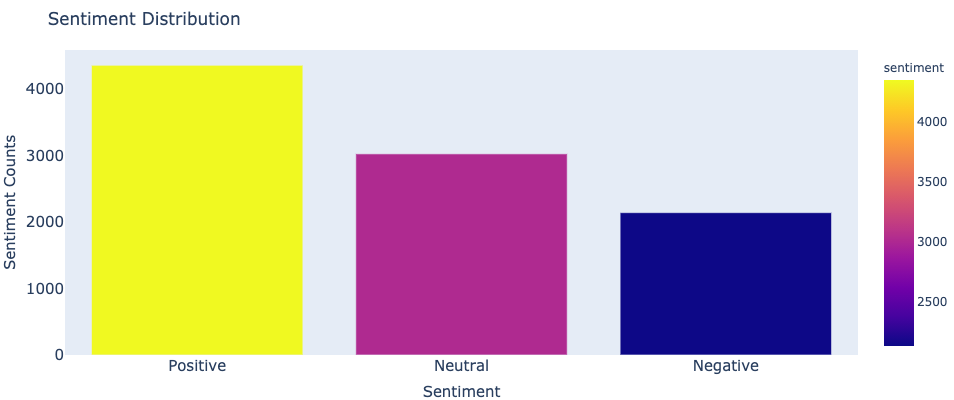

In [22]:
fig1 = px.bar(sentiment,
              x=sentiment.index,
              y='sentiment',
              color='sentiment'
             )
fig1.update_layout(
            height=400,
            width=700,
            margin={"r":0,"t":50,"l":0,"b":0},
            paper_bgcolor='white',
            title='Sentiment Distribution',
            xaxis_zeroline=False, 
            yaxis_zeroline=False,
    xaxis=dict(
            title='Sentiment',
            linecolor=None,
            titlefont_size=15,
            tickfont_size=15,
            showgrid=False
            ),
    yaxis=dict(
            title='Sentiment Counts',
            linecolor=None,
            titlefont_size=15,
            tickfont_size=15,
            showgrid=False
            ),
    legend=dict(
            x=0,
            y=0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
            )
                    )
iplot(fig1)

In [23]:
source_top10 = df_news['source'].value_counts(sort=True).nlargest(10)

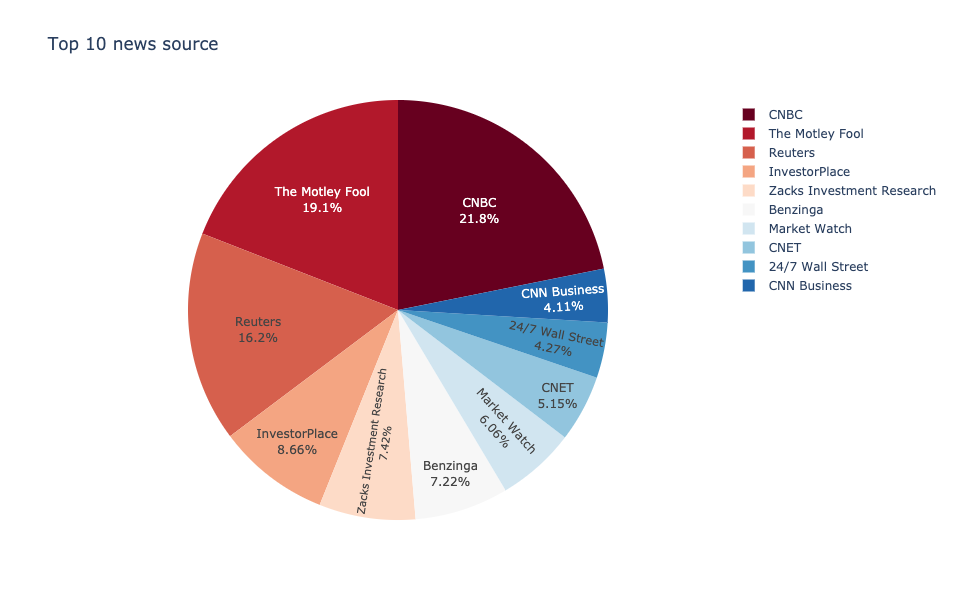

In [24]:
fig2 = px.pie(source_top10,
              values='source',
              names=source_top10.index,
              title='Top 10 news source',
              color_discrete_sequence=px.colors.sequential.RdBu,
              width=800,
              height=600,
              labels=source_top10.index
             )

fig2.update_traces(hoverinfo='label+percent',
                   textfont_size=12,
                   textposition='inside',
                   textinfo='percent+label'
                  )
iplot(fig2)

In [25]:
sent_vs_source_df = (
    df_news.groupby(['sentiment','source'])
    .size().reset_index()
    .rename(columns={0:'count'})
    .query("count > 50")
                    )

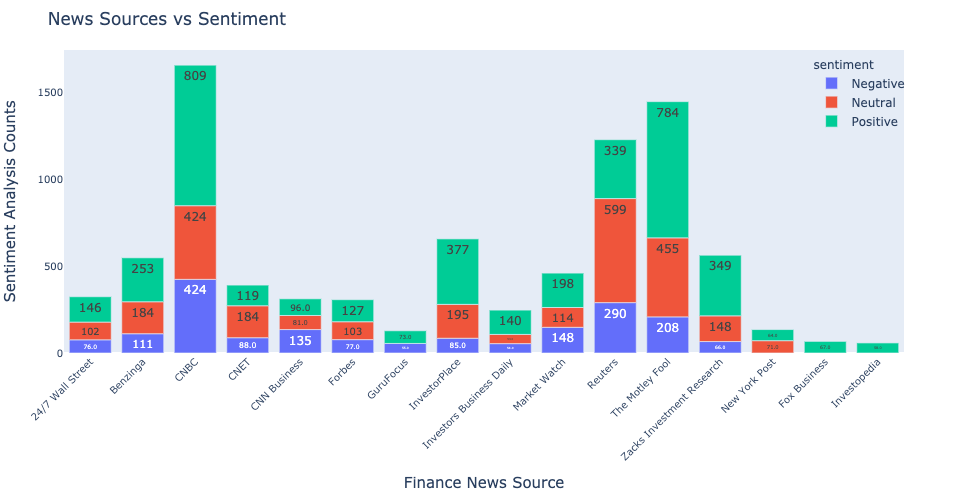

In [26]:
fig3 = px.bar(
    sent_vs_source_df,
    x='source',
    y='count',
    text='count',
    color='sentiment',
    title='News Sources vs Sentiment'
)
fig3.update_layout(
    width=1000,
    height=500,
    margin={"r":50,"t":50,"l":50,"b":50},
    uniformtext_minsize=6,

xaxis=dict(
    title='Finance News Source',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False,
    tickangle=-45
    ),
yaxis=dict(
    title='Sentiment Analysis Counts',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False
    ),    
legend=dict(
    yanchor="top",
    xanchor="left",
    x=0.89,
    y=0.99,
    bgcolor='rgba(255, 255, 255, 0)',
    bordercolor='rgba(255, 255, 255, 0)'
            )    
                )
fig3.update_traces(texttemplate='%{text:.3s}', textposition='inside')
iplot(fig3)

In [29]:
word_freq_dist = pd.concat(
    [
    (neutral_fdist_df
     .query("frequency > 1000")
     .assign(sentiment='neutral')
     .sample(15, replace=True)),
    (negative_fdist_df
     .query("frequency > 1000")
     .assign(sentiment='negative')
     .sample(15, replace=True)),        
    (positive_fdist_df
     .query("frequency > 1000")
     .assign(sentiment='positive')
     .sample(15, replace=True))
    ],
    ignore_index=True, axis=0
            )

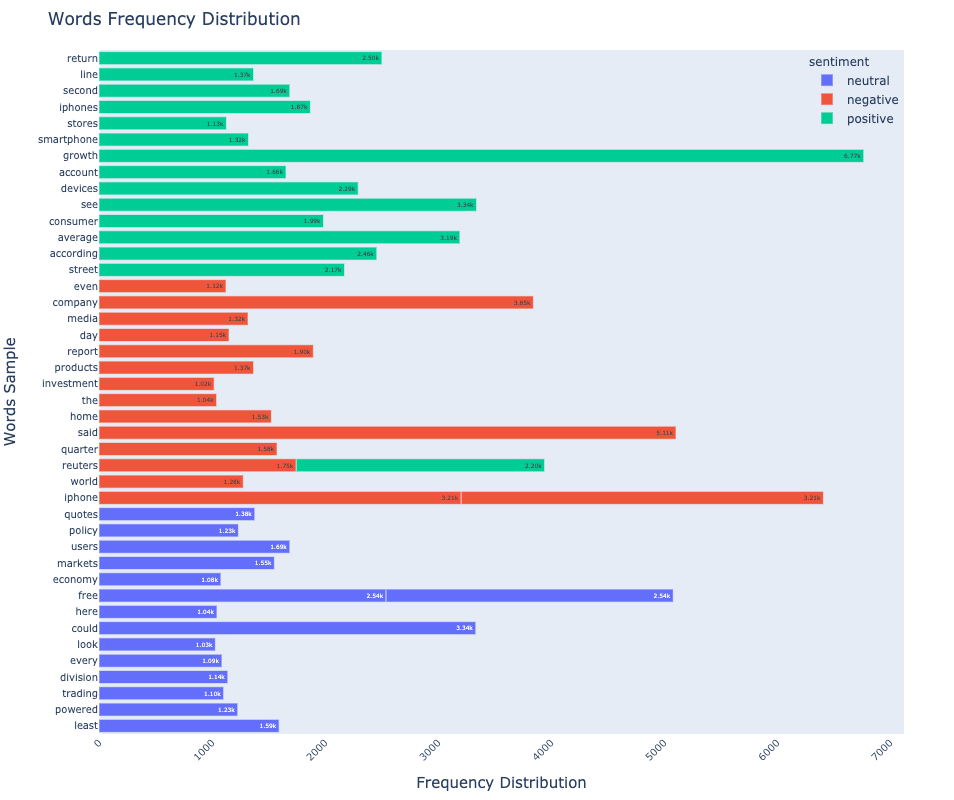

In [30]:
fig3 = px.bar(
    word_freq_dist,
    x='frequency',
    y='word',
    text='frequency',
    color='sentiment',
    title='Words Frequency Distribution'
)
fig3.update_layout(
    width=900,
    height=800,
    margin={"r":50,"t":50,"l":50,"b":50},
    uniformtext_minsize=6,

xaxis=dict(
    title='Frequency Distribution',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False,
    tickangle=-45
    ),
yaxis=dict(
    title='Words Sample',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False
    ),    
legend=dict(
    yanchor="top",
    xanchor="right",
    x=1,
    y=1,
    bgcolor='rgba(255, 255, 255, 0)',
    bordercolor='rgba(255, 255, 255, 0)'
            )    
                )
fig3.update_traces(texttemplate='%{text:.3s}', textposition='inside')
iplot(fig3)

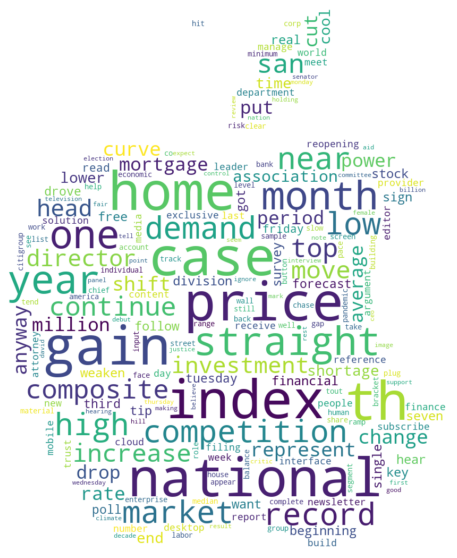

In [19]:
mask = load('./data/aapl_mask.pkl')
fig = plt.subplots(figsize=(20,10))
wc = WordCloud(
    mask=mask,
    ranks_only=True,
    background_color="white",
    collocations=True,
    max_words=200,
    max_font_size=100,
    random_state=42,
    width=1200,
    height=800
    )
wc.generate(' '.join(fdist_df.word.to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('./img/word_cloud.jpg',format="jpg")
plt.show()

In [49]:
# new_df = Project("2021-05-15", "2021-05-31", "AAPL", True, newsapi=True, finnhub=True, stocknews=True).run()